<a href="https://colab.research.google.com/github/charlie-aashutosh/Natural-Language-Processing-/blob/main/language_translation_IS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@author:Aashutosh Mishra

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.



In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [ ]:
deu_eng = deu_eng[:50000,:]

In [ ]:
#Let's take a look at our data
deu_eng


array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["I'm giving up smoking.", 'Ich höre mit dem Rauchen auf.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ["I'm glad I was nearby.",
        'Ich bin froh, dass ich in der Nähe war.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ["I'm glad Tom has gone.", 'Ich bin froh, dass Tom weg ist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

Text to Sequence Conversion:


To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})


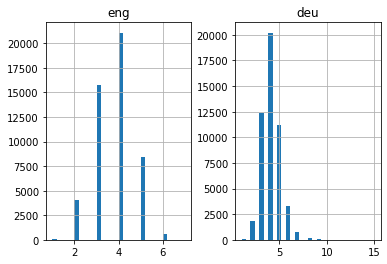

In [ ]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6255


In [ ]:

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10339


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [ ]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)


It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])



Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.

In [ ]:

# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.



In [ ]:

model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')


Please note that we have used 'sparse_categorical_crossentropy' as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using ModelCheckpoint() to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [ ]:
filename = 'model.h1.24_aashutosh'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=5, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/5
63/63 [==============================] - 30s 98ms/step - loss: 4.3800 - val_loss: 2.8848

Epoch 00001: val_loss improved from inf to 2.88485, saving model to model.h1.24_aashutosh


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


Epoch 2/5
63/63 [==============================] - 5s 75ms/step - loss: 2.7857 - val_loss: 2.7642

Epoch 00002: val_loss improved from 2.88485 to 2.76418, saving model to model.h1.24_aashutosh


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


Epoch 3/5
63/63 [==============================] - 5s 75ms/step - loss: 2.6441 - val_loss: 2.5638

Epoch 00003: val_loss improved from 2.76418 to 2.56381, saving model to model.h1.24_aashutosh


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


Epoch 4/5
63/63 [==============================] - 5s 74ms/step - loss: 2.4311 - val_loss: 2.4190

Epoch 00004: val_loss improved from 2.56381 to 2.41901, saving model to model.h1.24_aashutosh


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


Epoch 5/5
63/63 [==============================] - 5s 75ms/step - loss: 2.2888 - val_loss: 2.3518

Epoch 00005: val_loss improved from 2.41901 to 2.35178, saving model to model.h1.24_aashutosh


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


Let's compare the training loss and the validation loss.



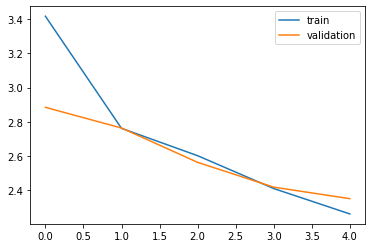

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Let's load the saved model to make predictions.

In [ ]:
model = load_model('model.h1.24_aashutosh')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})


In [ ]:
pd.set_option('display.max_colwidth', 200)


In [ ]:
pred_df.head(15)


,actual,predicted
0,I know that already.,i don't tom
1,Who's she?,it's is
2,Do you have it?,you
3,Use your feet.,don't are the
4,That was the trouble.,the a
5,He took off his coat.,he is a
6,Tom went sightseeing.,tom is a
7,I tried on the shoes.,i a
8,Open those doors.,the is
9,I've got to help Tom.,i can't tom


In [ ]:
pred_df.tail(15)


,actual,predicted
9985,They aren't twins.,it's you very
9986,"Come with me, OK?",what me
9987,I forgot my pencil.,i have a
9988,What a small world!,he me the
9989,I saw your father.,i have a
9990,Tom loves puzzles.,tom is
9991,I walked outside.,i am
9992,Who stayed?,she you
9993,Stop picking on Tom.,tom was
9994,My cat is white.,he is a
